In [1]:
!nvidia-smi

Thu Mar 21 09:12:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               On  | 00000000:84:00.0 Off |                  Off |
| 41%   30C    P8              14W / 135W |      8MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
! pip install -q diffusers==0.25.1 transformers gdown bitsandbytes accelerate datasets wandb

In [3]:
!pip install --upgrade gdown -q

In [46]:
import os
import json
import accelerate
import wandb
import random
from datasets import Dataset, load_dataset, Features, Value
from PIL import Image
import numpy as np
import cv2
import datasets
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, DataCollatorWithPadding, AutoImageProcessor, UperNetForSemanticSegmentation

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionInpaintPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from controlnet_aux.processor import Processor
from controlnet_aux import HEDdetector, SamDetector
import pandas as pd
import matplotlib.pyplot as plt

from colors import ade_palette
from utils import map_colors_rgb
from colors import OBJECTS, SITTING, LIGHTING, TABLES, CLOSETS, OFFICE, KITCHEN, BATHROOM

In [7]:
!gdown 1RdQjYlN6xIdcL8qp-T3cDjhTFvcXaT9A # /development_data-v0.2.zip
!gdown 

Downloading...
From: https://drive.google.com/uc?id=1RdQjYlN6xIdcL8qp-T3cDjhTFvcXaT9A
To: /development_data-v0.2.zip
100%|██████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 44.6MB/s]


In [8]:
!unzip -q '/development_data-v0.2.zip' -d '/'

In [42]:
import pandas as pd
aicrowd_dataset = pd.read_csv('//development_data-v0.2/all_input_list.csv', sep='\t')
aicrowd_dataset.head()

,img_path,text_prompt
0,bedroom_1.jpg,An elegantly appointed bedroom in the Art Deco...
1,bedroom_2.jpg,A bedroom that exudes French country charm wit...
2,bedroom_3.jpg,"A bedroom with a bohemian spirit, centered aro..."
3,children_room_1.jpg,A whimsical bohemian-themed children's room ad...
4,children_room_2.jpg,A serene and playful Scandinavian-style childr...


In [9]:
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-inpainting", subfolder="tokenizer")

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

In [10]:
def resize_dimensions(dimensions, target_size):
    """
    Resize PIL to target size while maintaining aspect ratio
    If smaller than target size leave it as is
    """
    width, height = dimensions

    # Check if both dimensions are smaller than the target size
    if width < target_size and height < target_size:
        return dimensions

    # Determine the larger side
    if width > height:
        # Calculate the aspect ratio
        aspect_ratio = height / width
        # Resize dimensions
        return (target_size, int(target_size * aspect_ratio))
    else:
        # Calculate the aspect ratio
        aspect_ratio = width / height
        # Resize dimensions
        return (int(target_size * aspect_ratio), target_size)

In [11]:
def filter_items(colors_list,items_list,items_to_mask):
    """
    Filters items and their corresponding colors from given lists, excluding
    specified items.

    Args:
        colors_list: A list or numpy array of colors corresponding to items.
        items_list: A list or numpy array of items.
        items_to_remove: A list or numpy array of items to be removed.

    Returns:
        A tuple of two lists or numpy arrays: filtered colors and filtered
        items.
    """
    filtered_colors = []
    filtered_items = []
    for color, item in zip(colors_list, items_list):
        if item not in items_to_mask:
            # print(f'Item not in mask : {item} - {color}')
            filtered_colors.append(color)
            filtered_items.append(item)
        # else:
        #     print(f'Item in mask : {item} - {color}')
    return filtered_colors, filtered_items

In [12]:
def filter_items_retain(colors_list,items_list,items_to_retain):
    """
    Filters items and their corresponding colors from given lists, excluding
    specified items.

    Args:
        colors_list: A list or numpy array of colors corresponding to items.
        items_list: A list or numpy array of items.
        items_to_remove: A list or numpy array of items to be removed.

    Returns:
        A tuple of two lists or numpy arrays: filtered colors and filtered
        items.
    """
    filtered_colors = []
    filtered_items = []
    for color, item in zip(colors_list, items_list):
        if item in items_to_retain:
            filtered_colors.append(color)
            filtered_items.append(item)
    return filtered_colors, filtered_items

In [13]:
def get_segmentation_pipeline():
    """Method to load the segmentation pipeline
    Returns:
        Tuple[AutoImageProcessor, UperNetForSemanticSegmentation]: segmentation pipeline
    """
    image_processor = AutoImageProcessor.from_pretrained(
        "openmmlab/upernet-convnext-large"
    )
    image_segmentor = UperNetForSemanticSegmentation.from_pretrained(
        "openmmlab/upernet-convnext-large"
    )

    # image_segmentor = image_segmentor.to('cuda')
    return image_processor, image_segmentor

In [14]:
@torch.inference_mode()
@torch.autocast('cuda')
def segment_image(image, image_processor, image_segmentor):
    """
    Segments an image using a semantic segmentation model.

    Args:
        image (Image): The input image to be segmented.
        image_processor (AutoImageProcessor): The processor to prepare the
            image for segmentation.
        image_segmentor (UperNetForSemanticSegmentation): The semantic
            segmentation model used to identify different segments in the image.

    Returns:
        Image: The segmented image with each segment colored differently based
            on its identified class.
    """
    # image_processor, image_segmentor = get_segmentation_pipeline()
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    with torch.no_grad():
        outputs = image_segmentor(pixel_values)

    seg = image_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[image.size[::-1]])[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    color_seg = color_seg.astype(np.uint8)
    seg_image = Image.fromarray(color_seg).convert('RGB')
    return seg_image

In [15]:
def generate_window_mask(input_image, seg_image_processor, seg_image_segmentor, object_items):
    real_seg = np.array(segment_image(input_image,
                                      seg_image_processor,
                                      seg_image_segmentor))
    real_seg_pil = Image.fromarray(real_seg)
    print(f'real_seg.shape : {real_seg.shape}')
    real_seg_pil.save('/real_seg.jpg')
    unique_colors = np.unique(real_seg.reshape(-1, real_seg.shape[2]), axis=0)
    unique_colors = [tuple(color) for color in unique_colors]
    segment_items = [map_colors_rgb(i) for i in unique_colors]
    print(f'unique_colors: {unique_colors}')
    print(f'segment_items: {segment_items}')
    chosen_colors, segment_items_1 = filter_items(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_mask=object_items
    )
    mask = np.zeros_like(real_seg)
    for color in chosen_colors:
        color_matches = (real_seg == color).all(axis=2)
        mask[color_matches] = 1

    mask_array = (mask * 255).astype(np.uint8)
    mask_image = Image.fromarray(mask_array).convert("L")
    mask_1_array = np.array(mask_image)
    mask_image.save('/window_mask_image_1.jpg')

    return mask_array, mask_image

In [16]:
input_img_path = '/development_data-v0.2/bedroom_1.jpg'
input_image = Image.open(input_img_path)

In [17]:
seg_image_processor, seg_image_segmentor = get_segmentation_pipeline()

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/940M [00:00<?, ?B/s]

In [18]:
object_items = ["windowpane;window",]
mask_array, mask_image = generate_window_mask(input_image, seg_image_processor, seg_image_segmentor, object_items)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


real_seg.shape : (2672, 4288, 3)
unique_colors: [(0, 61, 255), (0, 245, 255), (80, 50, 50), (120, 120, 80), (120, 120, 120), (230, 230, 230)]
segment_items: ['blind;screen', 'fan', 'floor;flooring', 'ceiling', 'wall', 'windowpane;window']


In [ ]:
mask_image.resize((224, 224))

In [ ]:
Image.open('real_seg.jpg').resize((224, 224))

In [ ]:
# Load the RGB mask image
mask_image = cv2.imread('real_seg.jpg')

# Define the color to be masked (230, 230, 230) in BGR format
mask_color = np.array([230, 230, 230])
print(f'type(mask_color): {type(mask_color)}, {mask_color.shape},   mask_image.shape : {mask_image.shape}')

# Threshold the mask image to extract the mask of the specified color
mask = cv2.inRange(mask_image, mask_color, mask_color)
# Image.fromarray(mask).resize((224, 224))

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw a black border around the outer contour
bordered_mask = cv2.drawContours(mask_image, contours, -1, (77, 77, 77), thickness=150)

Image.fromarray(bordered_mask).resize((224, 224))
cv2.imwrite("contours_only.jpg", bordered_mask)

In [ ]:
Image.open('contours_only.jpg').resize((224, 224))

In [ ]:
real_seg_pil_image = Image.open('contours_only.jpg')
real_seg_array = np.array(real_seg_pil_image)
print(real_seg_array.shape)
mask_bm = np.zeros_like(real_seg_array)
print(mask_bm.shape)
chosen_colors = [(77, 77, 77),]
for color in chosen_colors:
    print(color)
    color_matches = (real_seg_array == color).all(axis=2)
    mask_bm[color_matches] = 1
mask_bm_array = (mask_bm * 255).astype(np.uint8)
mask_bm_array = cv2.bitwise_not(mask_bm_array)
Image.fromarray(mask_bm_array).resize((224, 224))

In [20]:
def generate_mask(input_image, seg_image_processor, seg_image_segmentor, object_items):
    real_seg = np.array(segment_image(input_image,
                                      seg_image_processor,
                                      seg_image_segmentor))
    real_seg_pil = Image.fromarray(real_seg)
    image_area = real_seg.shape[0] * real_seg.shape[1]
    print(f'real_seg.shape : {real_seg.shape}, image_area : {image_area}')
    real_seg_pil.save('/real_seg.jpg')
    unique_colors = np.unique(real_seg.reshape(-1, real_seg.shape[2]), axis=0)
    unique_colors = [tuple(color) for color in unique_colors]
    segment_items = [map_colors_rgb(i) for i in unique_colors]
    print(f'unique_colors: {unique_colors}')
    print(f'segment_items: {segment_items}')
    # possible_mask_items = []
    # for item in segment_items:
    #     if item in object_items:
    #         possible_mask_items.append(item)
    # selected_item = [random.choice(possible_mask_items)]
    chosen_colors, segment_items_1 = filter_items(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_mask=object_items
    )
    print(f'object_items : {object_items}')
    print(f'chosen_colors : {chosen_colors}')
    print(f'segment_items_1 : {segment_items_1}')
    mask = np.zeros_like(real_seg)
    for color in chosen_colors:
        color_matches = (real_seg == color).all(axis=2)
        mask[color_matches] = 1

    mask_array = (mask * 255).astype(np.uint8)
    mask_image = Image.fromarray(mask_array).convert("L")
    mask_1_array = np.array(mask_image)
    mask_image.save('/mask_image.jpg')
    print(f' First mask image saved...')
    print(f'mask_1_array: {mask_1_array.shape}')
    object_items_2 = ["wall"]
    chosen_colors_2, segment_items_2 = filter_items(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_mask=object_items_2
    )
    mask_2 = np.zeros_like(real_seg)
    for color in chosen_colors_2:
        color_matches = (real_seg == color).all(axis=2)
        mask_2[color_matches] = 1

    mask_2_array = (mask_2 * 255).astype(np.uint8)
    mask_2_image = Image.fromarray(mask_2_array).convert("L")
    mask_2_image.save('/mask_2_image.jpg')
    print(f'mask_2_array.shape : {mask_2_array.shape}')

    # Find the wall height for each column of the image
    mask_3_array = np.array(mask_2_image)
    print(f'mask_3_array.shape : {mask_3_array.shape}')
    wall_heights = []
    for col in range(mask_3_array.shape[1]):
        # Find the black pixelsfrom the top of the column
        black_indices = np.nonzero(mask_3_array[:, col] == 0)[0]
        # print(f'type(black_indices) : {type(black_indices)}')
        if black_indices.size == 0:
            min_ = 0
            max_ = 6
        else:
            max_ = max(black_indices)
            min_ = min(black_indices)
        tup = (min_, max_)
        wall_heights.append(tup)

    height, width = mask_3_array.shape
    white_image_array = np.full((height, width), 255, dtype=np.uint8)

    for col_idx, coords in enumerate(wall_heights):
        min_, max_ = coords
        wall_ht = max_ - min_
        mask_wall_ht = int(0.30 * (wall_ht))
        new_max_ = min_ + mask_wall_ht
        for col in range(white_image_array.shape[1]):
            white_image_array[min_: new_max_, col_idx] = 0

    print(f'mask_1_array : {mask_1_array.shape}, white_image : {white_image_array.shape}')
    combined_mask_array = cv2.bitwise_and(mask_1_array, white_image_array)

    object_items_3 = ["windowpane;window"]
    chosen_colors_3, segment_items_3 = filter_items_retain(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_retain=object_items_3
    )
    # Define the color to be masked (230, 230, 230) in BGR format
    print(f'chosen_colors_3 : {chosen_colors_3}')
    window_color = np.array(chosen_colors_3)
    print(f'real_seg.shape : {real_seg.shape}, type(window_color) : {type(window_color)} , {window_color.shape}')

    # Threshold the mask image to extract the mask of the specified color
    window_mask = cv2.inRange(real_seg, window_color, window_color)
    # Image.fromarray(mask).resize((224, 224))
    # Find contours in the mask
    contours, _ = cv2.findContours(window_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw a black border around the outer contour
    bordered_mask = cv2.drawContours(real_seg, contours, -1, (77, 77, 77), thickness=20)
    bordered_mask_image = Image.fromarray(bordered_mask)
    bordered_mask_image.save('bordered_mask_image.jpg')
    real_seg_pil_2 = Image.fromarray(real_seg)
    real_seg_pil_2.save('/real_seg2.jpg')

    mask_4 = np.zeros_like(real_seg)
    border_colors = [(77, 77, 77)]
    for color in border_colors:
        color_matches = (real_seg == color).all(axis=2)
        mask_4[color_matches] = 1

    mask_4_array = (mask_4 * 255).astype(np.uint8)
    mask_4_array = cv2.bitwise_not(mask_4_array)
    mask_4_image = Image.fromarray(mask_4_array).convert("L")
    mask_4_image.save('/mask_4_image.jpg')
    mask_4_array = np.array(mask_4_image)
    print(f'combined_mask_array.shape  : {combined_mask_array.shape} mask_4_array.shape : {mask_4_array.shape}')
    final_mask_array = cv2.bitwise_and(combined_mask_array, mask_4_array)
    final_mask_image = Image.fromarray((final_mask_array).astype(np.uint8)).convert("RGB")
    final_mask_image.save('/final_mask_image.jpg')
    # print(f'final_mask_image.shape : {final_mask_image.shape}')
    return mask_array, mask_image, mask_2_array, mask_2_image, white_image_array, combined_mask_array, mask_4_array, final_mask_array

In [21]:
seg_image_processor, seg_image_segmentor = get_segmentation_pipeline()

# object_items_dict = [OBJECTS, SITTING, LIGHTING, TABLES, CLOSETS]
# object_items = []
# for dict_item in object_items_dict:
#     for colour, item in dict_item.items():
#         object_items.append(item)

In [27]:
input_image = Image.open('/development_data-v0.2/bedroom_1.jpg')
# input_image = Image.open('/demo_dataset/image_14.jpg').convert("RGB")
object_items = ["stairs;steps",
                "step;stair",
                "stairway;staircase",
                "radiator",
                "screen;door;screen",
                # "windowpane;window",
                "door;double;door",
                "countertop",
                "fireplace;hearth;open;fireplace",
                "column;pillar"]
mask_array, mask_image, mask_2_array, mask_2_image, white_image, combined_mask_array, mask_4_array, final_mask_array = generate_mask(input_image, seg_image_processor, seg_image_segmentor, object_items)

real_seg.shape : (2672, 4288, 3), image_area : 11457536
unique_colors: [(0, 61, 255), (0, 245, 255), (80, 50, 50), (120, 120, 80), (120, 120, 120), (230, 230, 230)]
segment_items: ['blind;screen', 'fan', 'floor;flooring', 'ceiling', 'wall', 'windowpane;window']
object_items : ['stairs;steps', 'step;stair', 'stairway;staircase', 'radiator', 'screen;door;screen', 'door;double;door', 'countertop', 'fireplace;hearth;open;fireplace', 'column;pillar']
chosen_colors : [(0, 61, 255), (0, 245, 255), (80, 50, 50), (120, 120, 80), (120, 120, 120), (230, 230, 230)]
segment_items_1 : ['blind;screen', 'fan', 'floor;flooring', 'ceiling', 'wall', 'windowpane;window']
 First mask image saved...
mask_1_array: (2672, 4288)
mask_2_array.shape : (2672, 4288, 3)
mask_3_array.shape : (2672, 4288)
mask_1_array : (2672, 4288), white_image : (2672, 4288)
chosen_colors_3 : [(230, 230, 230)]
real_seg.shape : (2672, 4288, 3), type(window_color) : <class 'numpy.ndarray'> , (1, 3)
combined_mask_array.shape  : (2672,

In [44]:
def find_area(seg_image_processor, seg_image_segmentor):
    for idx, row in aicrowd_dataset.iterrows():
        image_name = row['img_path']
        pos_prompt = row['text_prompt']

        empty_room_image = Image.open('development_data-v0.2/'+image_name)
        orig_w, orig_h = empty_room_image.size
        new_width, new_height = resize_dimensions(empty_room_image.size, 768)
        input_image = empty_room_image.resize((new_width, new_height))
        image_area = new_width * new_height

        real_seg = np.array(segment_image(input_image,
                                      seg_image_processor,
                                      seg_image_segmentor))
        unique_colors = np.unique(real_seg.reshape(-1, real_seg.shape[2]), axis=0)
        unique_colors = [tuple(color) for color in unique_colors]
        segment_items = [map_colors_rgb(i) for i in unique_colors]
        object_items_win = ["windowpane;window"]
        chosen_colors_win, segment_items_win = filter_items_retain(
            colors_list=unique_colors,
            items_list=segment_items,
            items_to_retain=object_items_win)

        win_color = np.array(chosen_colors_win)
        if win_color.shape == (0,):
            win_mask_area = 1
        else:
            win_mask = cv2.inRange(real_seg, win_color, win_color)
            win_mask_area = cv2.countNonZero(win_mask)
        win_area_ratio = win_mask_area / image_area
        # plt.imshow(np.array(input_image))
        # plt.axis('off')
        # plt.show()
        print(f'{idx}-{image_name}:win-area:{win_mask_area},image-area:{image_area},ratio:{win_area_ratio}')

In [45]:
find_area(seg_image_processor, seg_image_segmentor)

0-bedroom_1.jpg:win-area:132803,image-area:367104,ratio:0.36175852074616455
1-bedroom_2.jpg:win-area:19485,image-area:330240,ratio:0.05900254360465116
2-bedroom_3.jpg:win-area:31683,image-area:393216,ratio:0.08057403564453125
3-children_room_1.jpg:win-area:76504,image-area:329472,ratio:0.23220182595182595
4-children_room_2.jpg:win-area:39900,image-area:329472,ratio:0.12110285547785547
5-children_room_3.jpg:win-area:68126,image-area:401664,ratio:0.1696094247928617
6-dinning_room_1.jpg:win-area:68497,image-area:330240,ratio:0.2074158187984496
7-dinning_room_2.jpg:win-area:1,image-area:361728,ratio:2.7645081387119605e-06
8-dinning_room_3.jpg:win-area:34524,image-area:393216,ratio:0.087799072265625
9-home_office_1.jpg:win-area:1,image-area:441600,ratio:2.2644927536231883e-06
10-home_office_2.jpg:win-area:19709,image-area:589056,ratio:0.033458618535419385
11-home_office_3.jpg:win-area:42349,image-area:391680,ratio:0.10812142565359477
12-kitchen_1.jpg:win-area:1985,image-area:329472,ratio:0.

In [58]:
def generate_mask_area(image_name, input_image, seg_image_processor, seg_image_segmentor, object_items):
    real_seg = np.array(segment_image(input_image,
                                      seg_image_processor,
                                      seg_image_segmentor))
    real_seg_pil = Image.fromarray(real_seg)
    image_area = real_seg.shape[0] * real_seg.shape[1]
    # print(f'real_seg.shape : {real_seg.shape}, image_area : {image_area}')
    # real_seg_pil.save('/real_seg.jpg')
    unique_colors = np.unique(real_seg.reshape(-1, real_seg.shape[2]), axis=0)
    unique_colors = [tuple(color) for color in unique_colors]
    segment_items = [map_colors_rgb(i) for i in unique_colors]
    # print([{"color": color, "segment_items": name} for color, name in zip(unique_colors, segment_items)])
    
    object_items_win = ["windowpane;window"]
    chosen_colors_win, segment_items_win = filter_items_retain(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_retain=object_items_win)
    win_color = np.array(chosen_colors_win)
    if win_color.shape == (0,):
        win_mask_area = 1
    else:
        win_mask = cv2.inRange(real_seg, win_color, win_color)
        win_mask_area = cv2.countNonZero(win_mask)  
    win_area_ratio = win_mask_area / image_area
    # if win_area_ratio > 0.15:
    #     object_items.append("windowpane;window")
        
    chosen_colors, segment_items_1 = filter_items(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_mask=object_items
    )
    # print([{"inpaint_color": color, "inpaint_items": name} for color, name in zip(chosen_colors, segment_items_1)])
    mask = np.zeros_like(real_seg)
    for color in chosen_colors:
        color_matches = (real_seg == color).all(axis=2)
        mask[color_matches] = 1

    mask_array = (mask * 255).astype(np.uint8)
    mask_image = Image.fromarray(mask_array).convert("L")
    mask_1_array = np.array(mask_image)
    mask_image.save('/mask_image.jpg')
    # print(f'Initial mask image saved...mask_1_array: {mask_1_array.shape}')

    object_items_2 = ["wall"]
    chosen_colors_2, segment_items_2 = filter_items(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_mask=object_items_2
    )
    mask_2 = np.zeros_like(real_seg)
    for color in chosen_colors_2:
        color_matches = (real_seg == color).all(axis=2)
        mask_2[color_matches] = 1

    mask_2_array = (mask_2 * 255).astype(np.uint8)
    mask_2_image = Image.fromarray(mask_2_array).convert("L")
    mask_2_image.save('/mask_2_image.jpg')
    # print(f'Mask image with wall saved...mask_2_array.shape : {mask_2_array.shape}')

    # Find the wall height for each column of the image
    mask_3_array = np.array(mask_2_image)
    # print(f'Copy array of mask_2_image - mask_3_array.shape : {mask_3_array.shape}')
    wall_heights = []
    for col in range(mask_3_array.shape[1]):
        # Find the black pixelsfrom the top of the column
        black_indices = np.nonzero(mask_3_array[:, col] == 0)[0]
        # print(f'type(black_indices) : {type(black_indices)}')
        if black_indices.size == 0:
            min_ = 0
            max_ = 6
        else:
            max_ = max(black_indices)
            min_ = min(black_indices)
        tup = (min_, max_)
        wall_heights.append(tup)

    height, width = mask_3_array.shape
    white_image_array = np.full((height, width), 255, dtype=np.uint8)

    for col_idx, coords in enumerate(wall_heights):
        min_, max_ = coords
        wall_ht = max_ - min_
        mask_wall_ht = int(0.30 * (wall_ht))
        new_max_ = min_ + mask_wall_ht
        for col in range(white_image_array.shape[1]):
            white_image_array[min_: new_max_, col_idx] = 0

    # print(f'Verifying before combining - mask_1_array : {mask_1_array.shape}, white_image : {white_image_array.shape}')
    combined_mask_array = cv2.bitwise_and(mask_1_array, white_image_array)

    object_items_3 = ["windowpane;window"]
    chosen_colors_3, segment_items_3 = filter_items_retain(
        colors_list=unique_colors,
        items_list=segment_items,
        items_to_retain=object_items_3)
    # Define the color to be masked (230, 230, 230) in BGR format
    window_color = np.array(chosen_colors_3)
    # print(f'chosen_colors_3 : {chosen_colors_3}')
    # print(f'real_seg.shape : {real_seg.shape}, type(window_color) : {type(window_color)} , {window_color.shape}')

    if win_area_ratio < 0.15 and win_mask_area > 1:  # Smaller windows (<0.15) and making sure window is detected (>1), border mask
        # print(f'Smaller window : {win_area_ratio} & {win_mask_area}')                       
        # Threshold the mask image to extract the mask of the specified color
        window_mask = cv2.inRange(real_seg, window_color, window_color)
        # Find contours in the mask
        contours, _ = cv2.findContours(window_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        # Draw a (77, 77, 77) around the outer contour
        bordered_mask = cv2.drawContours(real_seg, contours, -1, (77, 77, 77), thickness=20)
        bordered_mask_image = Image.fromarray(bordered_mask)
        bordered_mask_image.save('bordered_mask_image.jpg')
    
        mask_4 = np.zeros_like(real_seg)
        border_colors = [(77, 77, 77)]
        for color in border_colors:
            color_matches = (real_seg == color).all(axis=2)
            mask_4[color_matches] = 1
    
        mask_4_array = (mask_4 * 255).astype(np.uint8)
        mask_4_array = cv2.bitwise_not(mask_4_array)
        mask_4_image = Image.fromarray(mask_4_array).convert("L")
        mask_4_image.save('/mask_4_image.jpg')
        mask_4_array = np.array(mask_4_image)
        # print(f'combined_mask_array.shape  : {combined_mask_array.shape} Window mask - mask_4_array.shape : {mask_4_array.shape}')
        final_mask_array = cv2.bitwise_and(combined_mask_array, mask_4_array)
        final_mask_image = Image.fromarray((final_mask_array).astype(np.uint8)).convert("RGB")
        # final_mask_image.save(f'/{image_name}_final_mask_image.jpg')
    else:
        # print(f'Bigger window OR window not there : {win_area_ratio} & {win_mask_area}')
        if win_color.shape == (0,):  # Window not detected
            final_mask_image = combined_mask_image
        else: # Bigger window, fully mask
            mask_4 = np.zeros_like(real_seg)
            for color in chosen_colors_3:
                color_matches = (real_seg == color).all(axis=2)
                mask_4[color_matches] = 1  
            mask_4_array = (mask_4 * 255).astype(np.uint8)
            mask_4_array = cv2.bitwise_not(mask_4_array)
            mask_4_image = Image.fromarray(mask_4_array).convert("L")
            mask_4_array = np.array(mask_4_image)                

            final_mask_array = cv2.bitwise_and(combined_mask_array, mask_4_array)
            final_mask_image = Image.fromarray((final_mask_array).astype(np.uint8)).convert("RGB")
            # final_mask_image.save(f'/{image_name}_final_mask_image.jpg')
    
    print(f'{image_name}:win-area:{win_mask_area},image-area:{image_area},ratio:{win_area_ratio}')
    plt.imshow(np.array(input_image))
    plt.axis('off')
    plt.show()
    plt.imshow(np.array(final_mask_image))
    plt.axis('off')
    plt.show()    

*****0*****
bedroom_1.jpg:win-area:4144945,image-area:11457536,ratio:0.3617658281850478


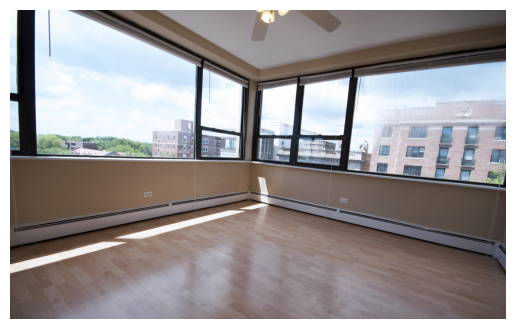

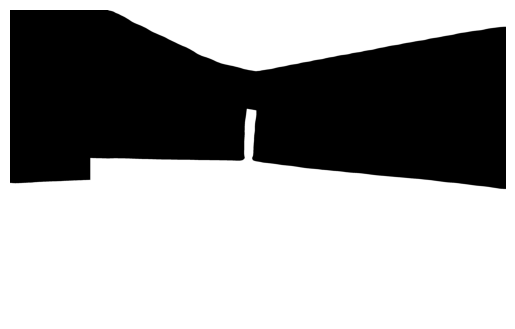

*****1*****
bedroom_2.jpg:win-area:70551,image-area:1188096,ratio:0.05938156512605042


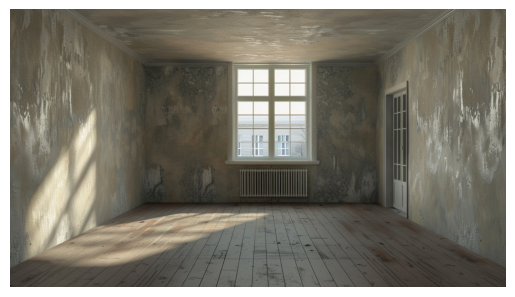

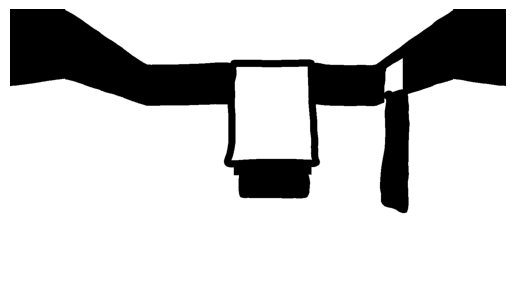

*****2*****
bedroom_3.jpg:win-area:96788,image-area:1204224,ratio:0.08037375106292517


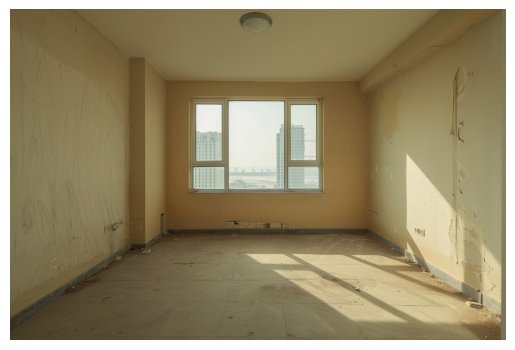

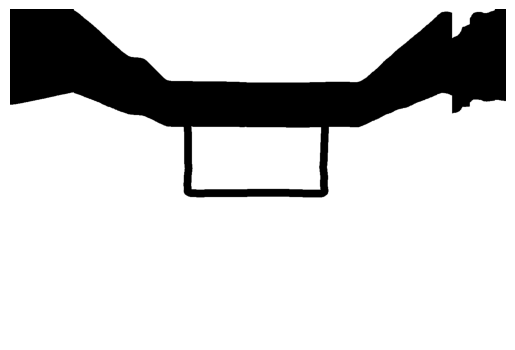

*****3*****
children_room_1.jpg:win-area:329469,image-area:1419363,ratio:0.2321245516474644


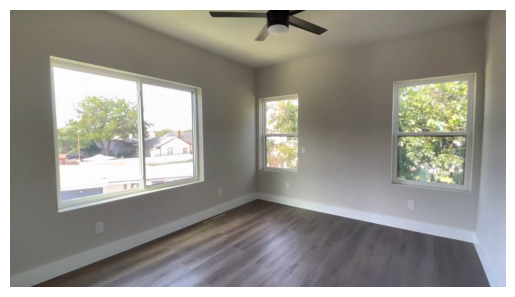

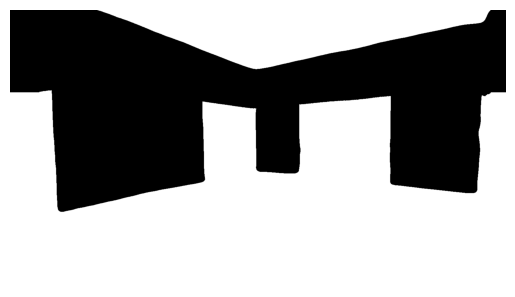

*****4*****
children_room_2.jpg:win-area:145965,image-area:1422740,ratio:0.10259428989133644


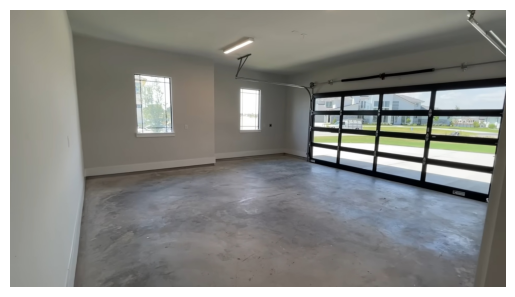

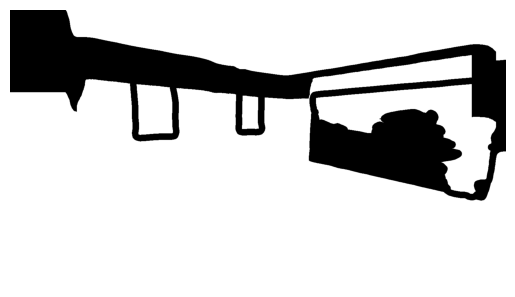

*****5*****
children_room_3.jpg:win-area:1897527,image-area:11351857,ratio:0.16715564686905413


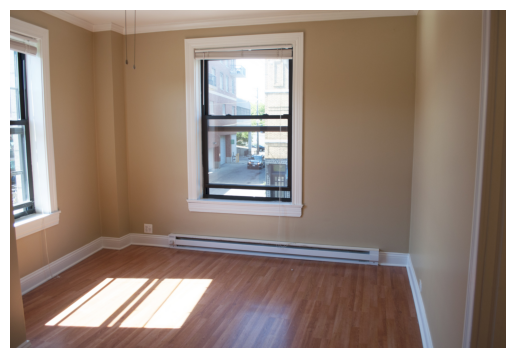

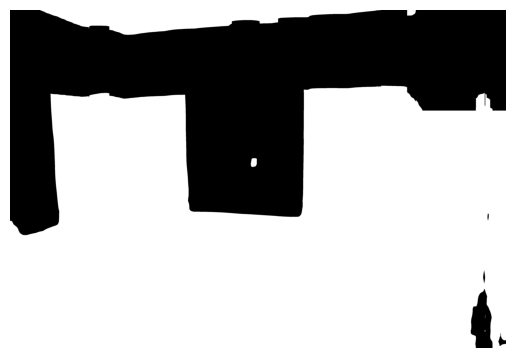

*****6*****
dinning_room_1.jpg:win-area:297839,image-area:1425036,ratio:0.20900454444659644


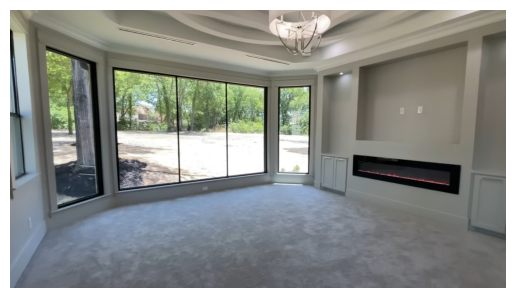

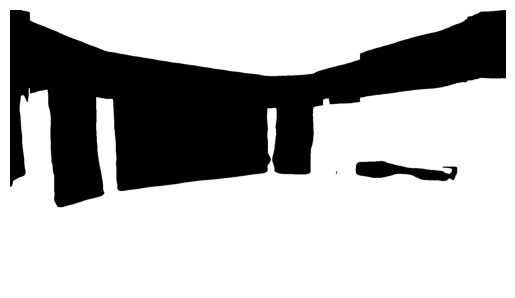

*****7*****


NameError: name 'combined_mask_image' is not defined

In [59]:
# input_image = Image.open('/development_data-v0.2/bedroom_1.jpg')
# # input_image = Image.open('/demo_dataset/image_14.jpg').convert("RGB")
object_items = ["stairs;steps",
                "step;stair",
                "stairway;staircase",
                "radiator",
                "screen;door;screen",
                # "windowpane;window",
                "door;double;door",
                "countertop",
                "fireplace;hearth;open;fireplace",
                "column;pillar"]
for idx, row in aicrowd_dataset.iterrows():
    print(f'*****{idx}*****')
    image_name = row['img_path']
    pos_prompt = row['text_prompt']
    input_image = Image.open(f'/development_data-v0.2/{image_name}')
    generate_mask_area(image_name, input_image, seg_image_processor, seg_image_segmentor, object_items)